# Analysis Tutorial

This tutorial demonstrates how to analyze and interpret the outputs from Connectomemapper 3. In particular it will tell you how to:

- Get the list of connectome files with [Pybids](https://pypi.org/project/pybids/)
- Read the .tsv connectome files with [Networkx](https://pypi.org/project/networkx/) and [Pandas](https://pandas.pydata.org/)
- Read the .gpickle files with Networkx
- Read the .mat files with [Scipy](https://scipy.org/)
- Compute the connectome harmonics with [PyGSP](https://pygsp.readthedocs.io/en/stable/index.html)
- Visualize the harmonics with the plot functions of [Nilearn](https://nilearn.github.io/stable/index.html)

In [18]:
import nilearn
import os
import pygsp
import networkx as nx
import pandas as pd
import seaborn as sns
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
import datalad.api as dl
import scipy.io as sio
from bids import BIDSLayout
from nilearn import plotting, image, datasets

## Loading and Plotting Adjacency Matrices

For demonstration, we are going to use an example dataset from [Open Neuro](https://openneuro.org/datasets/ds003505/versions/1.0.2) that already contains output from Connectomemapper.

In [19]:
# download example dataset with datalad
# uncomment next line once the new dataset is up
#vepcon_data = dl.install(path=os.path.join("..", "..", "example_data"),
#                         source="https://github.com/OpenNeuroDatasets/ds003505.git")

As the dataset is in [BIDS](https://bids.neuroimaging.io/), we can use [Pybids](https://bids-standard.github.io/pybids/) to help us load the data.

In [20]:
#layout = BIDSLayout(vepcon_data.path)
# add derivative folder containing the connectivity matrices
#layout.add_derivatives(os.path.join(vepcon_data.path, "derivatives", "cmp-v3.0.0-beta-RC1"))

In [21]:
#layout = BIDSLayout(vepcon_data.path)
path = os.path.join("/home", "localadmin", "data", "ds003505-sample")
layout = BIDSLayout(path)
# add derivative folder containing the connectivity matrices
#layout.add_derivatives(os.path.join(vepcon_data.path, "derivatives", "cmp-v3.0.0-beta-RC1"))
layout.add_derivatives(os.path.join(path, "derivatives", "cmp-v3.0.1"))

Now we can easily query for the filenames of the files we are interested in using `layout.get`. We will ask for the connectivity matrix of subject 01, scale 3, in tsv format. It will be returned as a list of file paths (in this case containing just one element).

In [22]:
conn_tsv_scale3 = layout.get(subject='01', extension='tsv',
                             suffix='connectivity', return_type='filename',
                             res='scale3')
conn_tsv_scale3

['/home/localadmin/data/ds003505-sample/derivatives/cmp-v3.0.1/sub-01/dwi/sub-01_atlas-L2018_res-scale3_conndata-network_connectivity.tsv']

We can then use [Pandas](https://pandas.pydata.org/) to read the file and display it as a table.

In [23]:
#edges = pd.read_csv(con_files[0], delimiter="\t")
edges = pd.read_csv(conn_tsv_scale3[0], delimiter="\t")
edges.head()

,source,target,number_of_fibers,fiber_length_mean,fiber_length_median,fiber_length_std,fiber_proportion,fiber_density,normalized_fiber_density,FA_mean,FA_std,FA_median,ADC_mean,ADC_std,ADC_median
0,1,1,578,6.577855,6.000000,2.086783,0.139558,0.024422,0.067457,0.190930,0.076994,0.176868,0.000787,0.000086,0.000775
1,1,3,254,9.507873,8.000008,4.339883,0.061328,0.007618,0.021041,0.184138,0.079206,0.172769,0.000801,0.000073,0.000799
2,1,9,101,10.198020,8.500000,4.645918,0.024386,0.003385,0.009351,0.258646,0.100590,0.252733,0.000780,0.000101,0.000756
3,1,2,98,7.704082,6.999998,2.756104,0.023662,0.003056,0.008441,0.247499,0.109299,0.247938,0.000815,0.000060,0.000812
4,1,113,59,10.203390,9.500001,3.235289,0.014245,0.002269,0.006268,0.243196,0.059146,0.241589,0.000858,0.000121,0.000855


Using [Networkx](https://networkx.org/documentation/stable/index.html), we can convert this table to a network graph. From that, we can convert individual measures to a [Numpy](https://numpy.org/) array. The array format is especially useful, as it allows us to plot the edge weights easily.

In [24]:
G = nx.from_pandas_edgelist(edges, edge_attr=True)
A_fiber_density = nx.to_numpy_array(G, weight="fiber_density")

Let's plot some of those adjacency matrices using [Matplotlib](https://matplotlib.org/) and [Seaborn](http://seaborn.pydata.org/index.html):

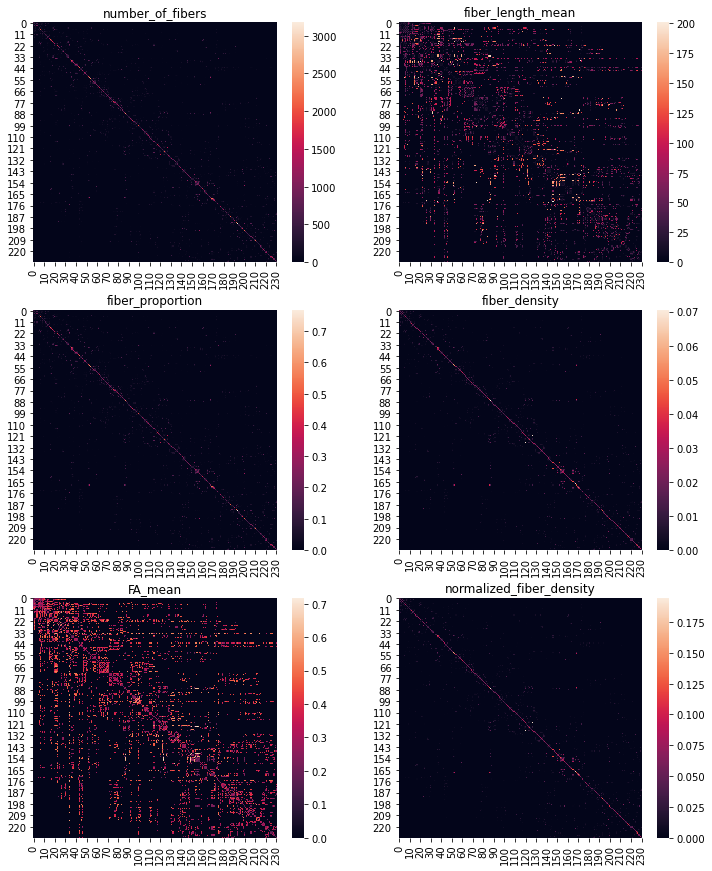

In [25]:
cols_to_plot = ["number_of_fibers", "fiber_length_mean",
                "fiber_proportion", "fiber_density",
                "FA_mean", "normalized_fiber_density"]

fig, axs = plt.subplots(3,2, figsize=(12,15))
axs = axs.flatten()
for c, ax in zip(cols_to_plot, axs):
    A = nx.to_numpy_array(G, weight=c)
    sns.heatmap(A, ax=ax)
    ax.set_title(c)

Alternatively, we can also load the matrices in network format, by reading the gpickle files using Networkx:

In [26]:
conn_gpickle_scale3 = layout.get(subject='01', extension='gpickle',
                                 suffix='connectivity',
                                 return_type='filename',
                                 res='scale3')
G = nx.read_gpickle(conn_gpickle_scale3[0])  # same format as with tsv

...or load the .mat files with [Scipy](https://scipy.org/):

In [27]:
conn_mat_scale3 = layout.get(subject='01', extension='mat',
                             suffix='connectivity', return_type='filename',
                             res='scale3')
A_mat = sio.loadmat(conn_mat_scale3[0])

The adjacency matrices here can be accessed like this:

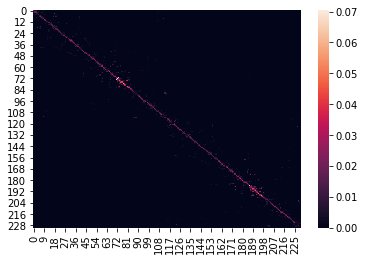

In [28]:
sns.heatmap(A_mat["sc"]["fiber_density"][0][0])
plt.show()

## Graph Signal Processing with Structural Connectivity

The package [PyGSP](https://pygsp.readthedocs.io/en/stable/index.html) offers a range of graph signal processing tools we can use on our structural connectivity data. In particular, we can do an eigendecomposition of the [graph Laplacian](https://en.wikipedia.org/wiki/Laplacian_matrix) to get the Fourier basis - the connectome harmonics.

Even though it is possible to also do this for subcortical regions, for the sake of plotting it is easier just to work with the cortical regions. To identify those, we need the parcellation labels.

In [29]:
# UPDATE PATH ONCE AVAILABLE
anat_folder = "/home/localadmin/data/ds003505-sample/derivatives/cmp-v3.0.1/sub-01/anat"
# read label tsv file
label_path = os.path.join(anat_folder, "sub-01_atlas-L2018_res-scale3_dseg.tsv")
labels = pd.read_csv(label_path, sep="\t", index_col=0)
# reset index to start at 0
labels.reset_index(inplace=True)
# select cortex labels
labels_ctx = labels["name"][[n.startswith("ctx") for n in labels["name"]]].copy()
idx = list(labels_ctx.index)
# select rows with cortical areas
#A_fd_ctx = A_fiber_density[idx]
A = nx.to_numpy_array(G, weight="FA_mean")
A_fd_ctx = A[idx]
# select columns with cortical areas
A_fd_ctx = A_fd_ctx[:,idx]

In [30]:
A_fd_ctx.shape

(216, 216)

Now we can compute the harmonics:

In [31]:
np.fill_diagonal(A_fd_ctx, 0)  # PyGSP does not support self-loops
G_fd = pygsp.graphs.Graph(A_fd_ctx)  # PyGSP graph
G_fd.compute_laplacian(lap_type="normalized")
G_fd.compute_fourier_basis()  # compute connectome harmonics

The harmonics have the same dimensions as our original adjacency matrix.

In [32]:
G_fd.U.shape

(216, 216)

Each column contains one basis vector. [Nilearn](https://nilearn.github.io/stable/index.html) offers a quick and easy way to plot them. For this, we need the center coordinates of each region in the parcellation in MNI space. For the tutorial, they are already precomputed, but in the cell below you find the code how to extract them yourself. **TO DO: how can people find the parcellation files in MNI space?**

In [33]:
# # set path to parcellation
# parcellation_folder = "/home/localadmin/data/parcellation/sub-colin27/anat"
# for scale in range(1,6):
#     # read label tsv file
#     label_path = os.path.join(anat_folder, f"sub-01_atlas-L2018_res-scale{scale}_dseg.tsv")
#     labels = pd.read_csv(label_path, sep="\t", index_col=0)
#     # reset index to start at 0
#     labels.reset_index(inplace=True)
#     # select cortex labels
#     labels_ctx = labels["name"][[n.startswith("ctx") for n in labels["name"]]].copy()
#     idx = list(labels_ctx.index)
#     parc_img = os.path.join(parcellation_folder, f"sub-colin27_atlas-L2018_res-scale{scale}_dseg.nii.gz")
#     # find center coordinates for each region
#     coords = plotting.find_parcellation_cut_coords(parc_img)
#     # subset: only cortical coordinates
#     coords_ctx = coords[idx]
#     # save as csv
#     coords_ctx_df = pd.DataFrame(coords_ctx)
#     coords_ctx_df.to_csv(f"coordinates_scale{scale}.csv")

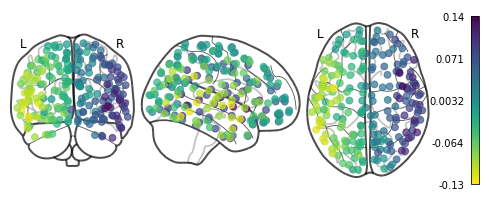

In [34]:
# load coordinates
coords_ctx_df = pd.read_csv("coordinates_scale3.csv", index_col=0)
coords_ctx = coords_ctx_df.to_numpy()
# plot
plotting.plot_markers(G_fd.U[:,1], coords_ctx)

A prettier version is to plot the connectome harmonics on a brain surface:

In [35]:
def plot_surface_ctx(roi_values, scale, cmp_dir, cmap="Spectral", save_fig=False,
                     output_dir="./", fmt="png"):
    """
    Plots a set of values on a cortex surface.
    
    Parameters
    ----------
    roi_values: numpy array
        The values to be plotted on the surface. The array should
        have as many values as regions of interest.
    scale: int
        Scale of the Lausanne 2018 atlas to be used.
    cmp_dir: string
        Directory of Connectomemapper3.
    cmap: string
        Colormap to use for plotting, default "Spectral".
    save_fig: bool
        Whether to save the generated figures, default False.
    output_dir: string
        Directory to save the figures, only used when
        save_fig == True.
    fmt: string
        Format to save the figures in, default "png", also
        accepted are "pdf", and "svg" (and others, depending
        on the backend used).
    """
    # surface mesh
    fsaverage = datasets.fetch_surf_fsaverage(mesh="fsaverage")
    label_dir = cmp_dir+"/cmtklib/data/parcellation/lausanne2018"
    scale = scale

    # file paths to the annot files
    annots = [os.path.join(label_dir, f'rh.lausanne2008.scale{scale}.annot'),
              os.path.join(label_dir, f'lh.lausanne2008.scale{scale}.annot')]

    # read annot files
    annot_right = nb.freesurfer.read_annot(annots[0])
    annot_left = nb.freesurfer.read_annot(annots[1])

    # create vector to store intensity values (one value per vertex)
    roi_vect_right = np.zeros_like(annot_right[0], dtype=float)
    roi_vect_left = np.zeros_like(annot_left[0], dtype=float)

    # convert labels to strings, labels are the same as 2018 is symmetric
    labels = [str(elem, 'utf-8') for elem in annot_right[2]]

    # create roi vectors
    for i in range(len(labels[1:])):  # skip 'unknown'
        ids_roi = np.where(annot_right[0] == i+1)[0]
        roi_vect_right[ids_roi] = roi_values[i]

    for i in range(len(labels[1:])):  # skip 'unknown'
        ids_roi = np.where(annot_left[0] == i+1)[0]
        roi_vect_left[ids_roi] = roi_values[i+len(labels)-1]

    # get min and max values
    vmin = min(roi_values)
    vmax = max(roi_values)

    # center around 0
    max_val = max([abs(vmin), vmax])
    vmax = max_val
    vmin = -max_val

    # plot
    fig, axs = plt.subplots(subplot_kw={'projection': '3d'})
    plotting.plot_surf_roi(fsaverage['pial_right'], roi_map=roi_vect_right,
                           hemi='right', view='lateral',
                           bg_map=fsaverage['sulc_right'], bg_on_data=True,
                           darkness=.5, cmap=cmap,
                           vmin=vmin, vmax=vmax,
                           figure=fig)
    if save_fig:
        fig.savefig(f'{output_dir}/scale{scale}_right_lateral.{fmt}')

    fig, axs = plt.subplots(subplot_kw={'projection': '3d'})
    plotting.plot_surf_roi(fsaverage['pial_left'], roi_map=roi_vect_left,
                           hemi='left', view='lateral',
                           bg_map=fsaverage['sulc_left'], bg_on_data=True,
                           darkness=.5, cmap=cmap,
                           vmin=vmin, vmax=vmax,
                           figure=fig)
    if save_fig:
        fig.savefig(f'{output_dir}/scale{scale}_left_lateral.{fmt}')

    fig, axs = plt.subplots(subplot_kw={'projection': '3d'})
    plotting.plot_surf_roi(fsaverage['pial_right'], roi_map=roi_vect_right,
                           hemi='right', view='medial',
                           bg_map=fsaverage['sulc_right'], bg_on_data=True,
                           darkness=.5, cmap=cmap,
                           vmin=vmin, vmax=vmax,
                           figure=fig)
    if save_fig:
        fig.savefig(f'{output_dir}/scale{scale}_right_medial.{fmt}')

    fig, axs = plt.subplots(subplot_kw={'projection': '3d'})
    plotting.plot_surf_roi(fsaverage['pial_left'], roi_map=roi_vect_left,
                           hemi='left', view='medial',
                           bg_map=fsaverage['sulc_left'], bg_on_data=True,
                           darkness=.5, cmap=cmap,
                           vmin=vmin, vmax=vmax,
                           figure=fig)
    if save_fig:
        fig.savefig(f'{output_dir}/scale{scale}_left_medial.{fmt}')

    fig, axs = plt.subplots(subplot_kw={'projection': '3d'})
    plotting.plot_surf_roi(fsaverage['pial_right'], roi_map=roi_vect_right,
                           hemi='right', view='ventral',
                           bg_map=fsaverage['sulc_right'], bg_on_data=True,
                           darkness=.5, cmap=cmap,
                           vmin=vmin, vmax=vmax,
                           figure=fig)
    if save_fig:
        fig.savefig(f'{output_dir}/scale{scale}_right_ventral.{fmt}')

    fig, axs = plt.subplots(subplot_kw={'projection': '3d'})
    plotting.plot_surf_roi(fsaverage['pial_left'], roi_map=roi_vect_left,
                           hemi='left', view='ventral',
                           bg_map=fsaverage['sulc_left'], bg_on_data=True,
                           darkness=.5, cmap=cmap,
                           vmin=vmin, vmax=vmax,
                           figure=fig)
    if save_fig:
        fig.savefig(f'{output_dir}/scale{scale}_left_ventral.{fmt}')

    fig, axs = plt.subplots(subplot_kw={'projection': '3d'})
    plotting.plot_surf_roi(fsaverage['pial_right'], roi_map=roi_vect_right,
                           hemi='right', view='dorsal',
                           bg_map=fsaverage['sulc_right'], bg_on_data=True,
                           darkness=.5, cmap=cmap,
                           vmin=vmin, vmax=vmax,
                           figure=fig)
    if save_fig:
        fig.savefig(f'{output_dir}/scale{scale}_right_dorsal.{fmt}')

    fig, axs = plt.subplots(subplot_kw={'projection': '3d'})
    plotting.plot_surf_roi(fsaverage['pial_left'], roi_map=roi_vect_left,
                           hemi='left', view='dorsal',
                           bg_map=fsaverage['sulc_left'], bg_on_data=True,
                           darkness=.5, cmap=cmap,
                           vmin=vmin, vmax=vmax,
                           figure=fig)
    if save_fig:
        fig.savefig(f'{output_dir}/scale{scale}_left_dorsal.{fmt}')

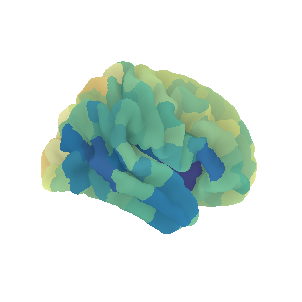

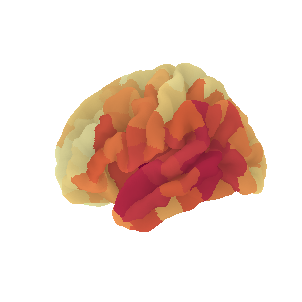

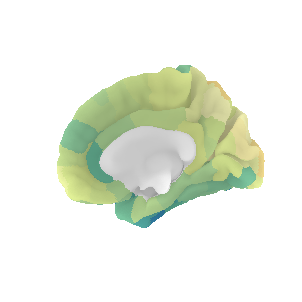

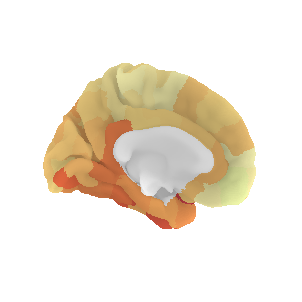

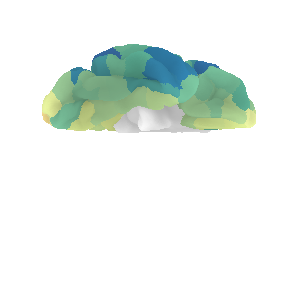

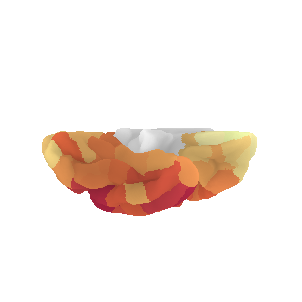

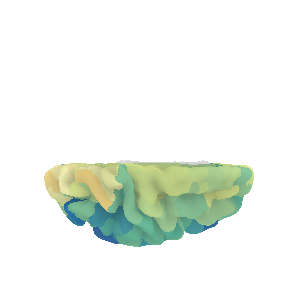

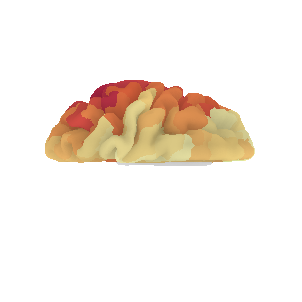

In [36]:
plot_surface_ctx(G_fd.U[:,1], 3, "/home/localadmin/connectomemapper3")

Pretty, right?

This concludes the tutorial. If you want to learn more about connectome harmonics, here are some references:

- Human brain networks function in connectome-specific harmonic waves (Atasoy et al., 2016, [link](https://www.nature.com/articles/ncomms10340)): Landmark paper that first applied graph signal processing to brain connectivity.

- Functional harmonics reveal multi-dimensional basis functions underlying cortical organization (Glomb et al., 2021, [link](https://doi.org/10.1016/j.celrep.2021.109554)): Connectome harmonics of functional connectivity.

- The connectome spectrum as a canonical basis for a sparse representation of fast brain activity (Rué-Queralt et al., 2021, [link](10.1016/j.neuroimage.2021.118611)): EEG and connectome harmonics.